# Transferencia de calor por conducción en 1D: <font color=green>Diferencias finitas con un esquema explícito</font>

**Trabajo realizado con el apoyo del Programa UNAM-DGAPA-PAPIME PE101019**

*   Autores: 
    - Luis M. de la Cruz Salas
*   Rev: mar nov 10 12:35:18 CDT 2020

<img src="./images/matematicoCOMPLETO.png" style="width: 300px;"/>

El modelo matemático de este problema consiste de la siguiente ecuación diferencial parcial:

$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left(\kappa \frac{\partial T}{\partial x}\right)
$

En este caso se busca una función que dependa de la posición y del tiempo: $T(x,t)$

<img src="./images/numericoCOMPLETO.png" style="width: 300px;"/>

Vamos a resolver este problema usando el método de diferencias finitas (FDM, por sus siglas en inglés), de tal manera que, aproximando los términos de la ecuación de este modelo y usando un esquema **explícito** tenemos lo siguiente:

$
T^{n+1}_{i} = T^{n}_{i} + \frac{\Delta t}{\Delta x^2} \kappa \left(T^{n}_{i-1} - 2 T^{n}_{i} + T^{n}_{i-1} \right), \text{ para } i = 1, \dots, N \text{ y } n = 1, \dots, \text{Tmax}.
$

donde se realizaron las siguiente aproximaciones:
$
\frac{\partial T}{\partial t} \approx  \frac{T^{n+1}_{i} - T^{n}_{i}}{\Delta t}
\quad
y
\quad
\frac{\partial}{\partial x} \left(\kappa \frac{\partial T}{\partial x}\right) \approx  \kappa \frac{T^{n}_{i-1} - 2 T^{n}_{i} + T^{n}_{i-1}}{\Delta x^2}
$


La relación de recurrencia anterior indica que se puede aproximar la temperatura en el nodo $i$ y en el instante $n+1$, mediante los valores de la temperatura en los nodos $i$, $i+1$ e $i-1$ calculados en un instante anterior $n$, es decir con cantidades que ya se conocen de antemano. Esto se puede ver en la siguiente figura:

<img src="./images/Stencil1D_DF_02.png" style="width: 600px;"/>


<img src="./images/computacionalCOMPLETO.png" style="width: 450px;"/>

Con toda la información anterior, vamos a implementar un algoritmo para obtener la temperatura de la barra en sus puntos interiores y en los instantes de tiempo $n = 1, \dots, $Tmax .

In [1]:
#-----------------------------------------------------------
# PARA DEFINIR EL PATH ABSOLUTO DE LOS MÓDULOS DE PYNOXTLI
#
import os, sys
sys.path.insert(0, os.path.abspath('../../base'))
#-----------------------------------------------------------

In [2]:
import numpy as np
#
# Importamos los módulos necesarios de PyNoxtli.
#
from geo.line import Line
from utils.displayInfo import printInfo
import vis.flowix as flx

In [3]:
#
# Primero definimos las propiedades física y geométricas de la barra:
#
longitud = 0.5 # metros
TA = 100 # °C
TB = 500 # °C
k  = 1000 # Conductividad térmica, W/m.K
N  = 6 # Número de nodos
dt = 0.000001
Tmax = 50 # Número de pasos en el tiempo

In [4]:
#
# Definición del dominio y condiciones de frontera
#
barra = Line(longitud) # Creación de la barra
barra.boundaryConditions(dirichlet = {'LEFT':TA, 'RIGHT':TB}) # Definición de las condiciones de frontera

malla = barra.constructMesh(N) # Se construye una malla genérica con el número de nodos
dx = malla.dx # Separación entre los puntos de la malla

In [5]:
#
# Imprimimos en pantalla los valores de cada parámetro
#
printInfo(Longitud = longitud,
          Temperatura_A = TA,
          Temperatura_B = TB,
          Conductividad = k,
          Nodos = malla.nx,
          Volúmenes = malla.vx,
          dx = malla.dx,
          Paso_de_tiemp = dt,
          Número_de_pasos = Tmax)

.--------------------------------------------------------------------------------.
|              PyNoxtli : Ver. 0.2, LMCS-2020, [GNU GPL License V3]              |
.--------------------------------------------------------------------------------.
|       Longitud = 5.000000000000000e-01                                         |
|  Temperatura_A =    100                                                        |
|  Temperatura_B =    500                                                        |
|  Conductividad =    1000                                                       |
|          Nodos =     6                                                         |
|      Volúmenes =     5                                                         |
|             dx = 1.000000000000000e-01                                         |
|  Paso_de_tiemp = 1.000000000000000e-06                                         |
|Número_de_pasos =     50                                                        |
.---

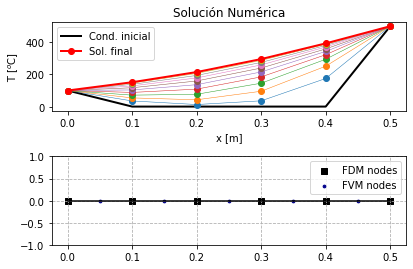

In [6]:
#
# Arreglo para almacenar la solución
#
T = np.zeros(malla.nx) # El arreglo contiene ceros inicialmente
#
# Condiciones de frontera
#
T[0]  = TA        # Condición de frontera izquierda
T[-1] = TB        # Condición de frontera derecha
#
# Se generan las coordenadas de la malla para FDM
#
x, _, _ = malla.coordinatesMeshFDM()
#
# Definimos algunos parámetros para los ejes de la solución.
#
param_ejes = [{'title':'Solución Numérica', 'xlabel':'x [m]', 'ylabel':'T [$^o$C]'}]
#
# Vamos a generar dos conjuntos de ejes, uno para la malla y otro para la solución.
#
v = flx.Plotter(2,1,param_ejes)
#
# Se grafica la malla en los ejes de etiqueta 2.
#
v.plot_mesh(2, malla, vol='.', nod = 's', label=True)
#
# En los ejes de etiqueta 1 se hace la gráfica de la condición inicial.
#
v.plot(1,x,T,{'marker':'', 'lw':2.0,'color':'k', 'label':'Cond. inicial'})
#
# Se calcula el coeficiente usado en la relación de recurrencia
#
c = k * dt / (dx * dx)
#
# Se obtiene la solución para cada punto y para cada paso de tiempo
# usando la relación de recurrencia.
#
Nfreq = 10
for t in range(1,Tmax):
    for i in range(1,N-1):
        T[i] = T[i] + c * (T[i-1] - 2 * T[i] + T[i+1])
    #
    # Solo se hace una gráfica cada 5 pasos de tiempo
    #
    if not(t % 5):
        v.plot(1,x,T,{'marker':'o','ls':'-', 'lw':0.5})
#
# Se grafica la solución en el paso de tiempo final.
#
v.plot(1,x,T,{'marker':'o','ls':'-', 'lw':2.0, 'color':'r', 'label':'Sol. final'})
#
# Se muestran todas las gráficas
#
v.legend()
v.show()